<a href="https://colab.research.google.com/github/SelenaNahra/MachineLearning/blob/main/ML_Report_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/150], Loss: 0.5015
Epoch [2/150], Loss: 0.1603
Epoch [3/150], Loss: 0.3505
Epoch [4/150], Loss: 0.2165
Epoch [5/150], Loss: 0.2327
Epoch [6/150], Loss: 0.3538
Epoch [7/150], Loss: 0.1899
Epoch [8/150], Loss: 0.3523
Epoch [9/150], Loss: 0.4039
Epoch [10/150], Loss: 0.1120
Epoch [11/150], Loss: 0.2329
Epoch [12/150], Loss: 0.2089
Epoch [13/150], Loss: 0.1874
Epoch [14/150], Loss: 0.3554
Epoch [15/150], Loss: 0.2529
Epoch [16/150], Loss: 0.1878
Epoch [17/150], Loss: 0.2742
Epoch [18/150], Loss: 0.1270
Epoch [19/150], Loss: 0.2779
Epoch [20/150], Loss: 0.1551
Epoch [21/150], Loss: 0.1458
Epoch [22/150], Loss: 0.3251
Epoch [23/150], Loss: 0.0937
Epoch [24/150], Loss: 0.1656
Epoch [25/150], Loss: 0.3065
Epoch [26/150], Loss: 0.3098
Epoch [27/150], Loss: 0.1661
Epoch [28/150], Loss: 0.2633
Epoch [29/150], Loss: 0.1557
Epoch [30/150], Loss: 0.2323
Epoch [31/150], Loss: 0.3143
Epoch [32/150], Loss: 0.3036
Epoch [33/150], Loss: 0.2519
Epoch [34/150], Loss: 0.1742
Epoch [35/150], Loss: 0

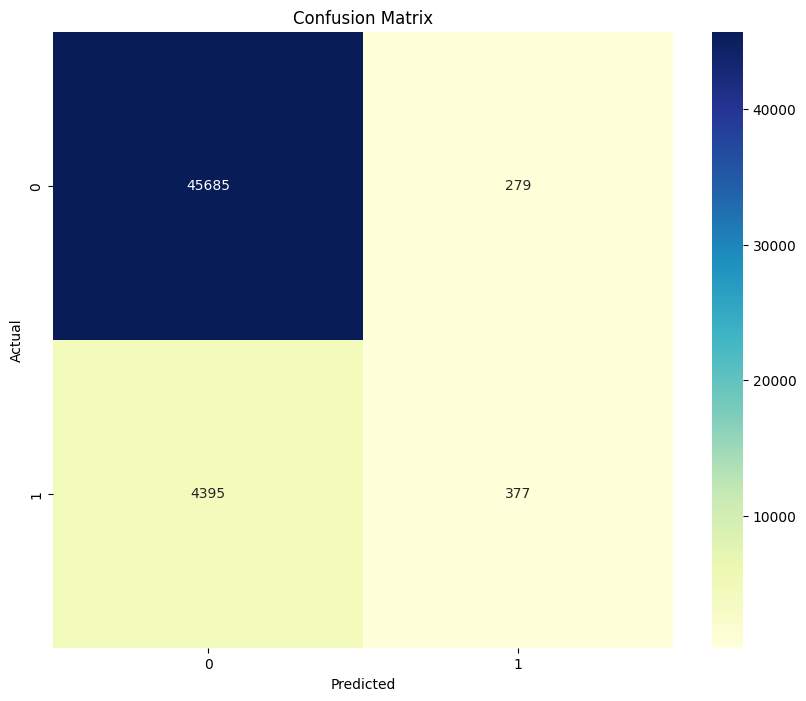

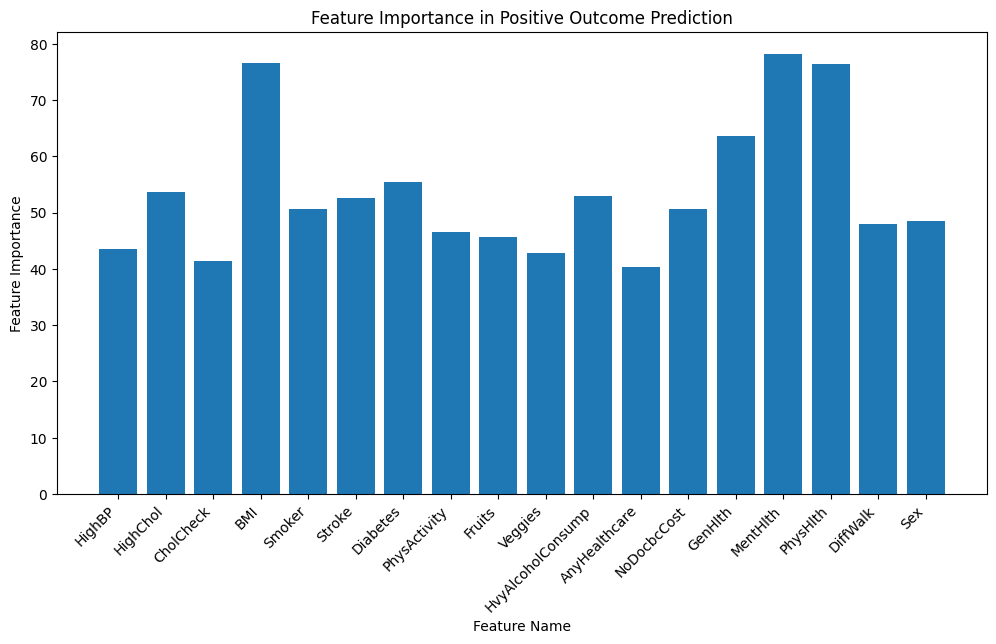

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
data = pd.read_csv("Project DataSet.csv")

# Extract features and target variable
x = data.iloc[:, 1:19].values
y = data.iloc[:, 0].values

column_to_modify1 = 'BMI'

# Change BMI: 1 = Obseity, 0 = Not Obese
data[column_to_modify1] = data[column_to_modify1].apply(lambda x: 1 if x >= 30 else 0)

column_to_modify2 = 'Diabetes'

# Change Diabetes: 1 = Type 1 or Type 2, 0 = Not Diabetic
data[column_to_modify2] = data[column_to_modify2].apply(lambda x: 1 if x >= 1 else 0)

# Convert to float before normalization
x = x.astype('float64')
y = y.astype('int64')

# Normalize features
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)

# Convert to PyTorch tensors
tensor_x = torch.tensor(x_normalized, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.long)

# Train and Validation split
x_train, x_test, y_train, y_test = train_test_split(tensor_x, tensor_y, test_size=0.20, random_state=0)

# Define FCNN model
class SimpleFCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = x_train.shape[1]  # Number of features
hidden_size = 64
output_size = 5  # Number of classes

batch_size = 32
learning_rate = 0.001
num_epochs = 150

# Instantiate the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFCNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validation loop
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predicted)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
f1 = f1_score(all_labels, all_predicted, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get the learned weights from the first layer
learned_weights = model.fc1.weight.detach().cpu().numpy()

# Get the column names
feature_names = data.columns[1:19]  # Assuming your features start from the second column, adjust if needed

# Calculate the absolute sum of weights for each feature
feature_importance = np.abs(learned_weights).sum(axis=0)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Positive Outcome Prediction')
plt.show()